## Medical image diagnosis challenge 

### 1. Load packages

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import collections

c:\Users\user\anaconda3\envs\pyt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Set hyperparameters
* About batch size & epoch
    * https://machine-learning.paperspace.com/wiki/epoch#:~:text=The%20number%20of%20iterations%20is,to%20complete%20a%20single%20epoch.
* There are other parts of the code that define hyperparameters as well.

In [10]:
batch_size=100 # 400 / 800
Epoch = 100 
Learning_rate=0.001  #0.01 / 0.1 

### 3. Load and preprocess the dataset



In [11]:
file_path="./data/"  # You must change file_path 

original_training_data=[]
test_img=[]

for i in range(400):
    raw_image_normal=Image.open(file_path+"training_images/normal"+str(i+1)+'.png')
    raw_image_normal=np.array(raw_image_normal)/255
    raw_image_normal = raw_image_normal[np.newaxis, :, :]
    original_training_data.append([raw_image_normal, [1,0]])

    raw_image_abnormal=Image.open(file_path+"training_images/abnormal"+str(i+1)+'.png')
    raw_image_abnormal=np.array(raw_image_abnormal)/255
    raw_image_abnormal=raw_image_abnormal[np.newaxis,:,:]
    original_training_data.append([raw_image_abnormal,[0,1]])

for i in range(50):
    raw_image_test=Image.open(file_path+"test_images/"+str(i+1)+'.png')
    raw_image_test=np.array(raw_image_test)/255
    raw_image_test = raw_image_test[np.newaxis, :, :]
    test_img.append(raw_image_test)
    
print(len(original_training_data)) # trianing set size
print(len(test_img))  # test set size
print(test_img[0].shape) # input shape

800
50
(1, 128, 128)


### 4. Separate the dataset (training set & validation set)

* The size of the validation set is a hyperparameter.

In [13]:
random.shuffle(original_training_data)
selected_training_data=original_training_data[:360] 
validation_data=original_training_data[360:] 

print(len(selected_training_data)) # training set size
print(len(validation_data)) # validation set size

360
440


### 5. Define functions: batch sampling & validation data extraction



In [14]:

def batch_sampling (num):
    global selected_training_data

    if num==0:
        random.shuffle(selected_training_data)

    x_size=0
    train_x=[]
    train_y=[]
    for i in range(batch_size):
        try:
            train_x.append(selected_training_data[num*batch_size+i][0])
            train_y.append(selected_training_data[num*batch_size+i][1])
            x_size+=1
        except:
            break

    return torch.from_numpy(np.array(train_x)).float(), torch.from_numpy(np.array(train_y)).long(), x_size

def extract_validation_data ():
    global validation_data
    x_size = 0
    val_x=[]
    val_y=[]
    for i in range(len(validation_data)):
        val_x.append(validation_data[i][0])
        val_y.append(validation_data[i][1])
        x_size += 1
    return torch.from_numpy(np.array(val_x)).float(), torch.from_numpy(np.array(val_y)).long(), x_size


### 6. Define a neural network

* You can freely modify hyperparameters in the below part (number of layers, number of units, size of the kernel, etc.).
* You don't have to use a CNN. Try any other models if you want.
* For more details about the network components, check https://pytorch.org/docs/stable/index.html

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5,stride = 1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 4, kernel_size = 3,stride = 1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 4, 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 2)
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 32 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)
    
net = Net() # make an instance
print(net) # check the architecture
print(net(torch.randn(10,1,128,128))) # see the network works correctly with an arbitrary input

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)
tensor([[0.5356, 0.4644],
        [0.5377, 0.4623],
        [0.5350, 0.4650],
        [0.5385, 0.4615],
        [0.5399, 0.4601],
        [0.5291, 0.4709],
        [0.5320, 0.4680],
        [0.5370, 0.4630],
        [0.5316, 0.4684],
        [0.5378, 0.4622]], grad_fn=<SoftmaxBackward0>)


### 7. Define a loss function and optimizer

In [16]:
def criterion(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-9, 1 - 1e-9)
    return -(y_true * torch.log(y_pred)).sum(dim=1).mean()

optimizer = optim.Adam(net.parameters(), lr=Learning_rate) 
optimizer.state = collections.defaultdict(dict) # network initialization

### 8. Train the network and print the test output

In [17]:
batch_number=int((len(selected_training_data)-0.5)/batch_size)+1 
train_loss_epoch = [] 
val_loss_epoch = [] 
train_acc_epoch = [] 
val_acc_epoch = [] 
for epoch in range(Epoch):
    net.train()
    for batch in range(batch_number):
        train_x, train_y, x_size = batch_sampling(batch)
        optimizer.zero_grad()  # Gradient Reset
        output = net(train_x)

        loss = criterion(output, train_y)

        loss.backward()  # Back propagation
        optimizer.step()

    with torch.no_grad():
        net.eval()
        print("Epoch ", epoch)
        training_loss=0
        training_accuracy=0
        for batch in range(batch_number):
            train_x, train_y, x_size = batch_sampling(batch)
            output = net(train_x)

            training_loss += x_size*criterion(output, train_y).item()

            _, predicted = torch.max(output.data, 1)
            _, label_index = torch.max(train_y, 1)
            training_accuracy+=(predicted == label_index).sum().item()

        training_accuracy=training_accuracy/len(selected_training_data)
        training_loss=training_loss/len(selected_training_data)
        train_acc_epoch.append(training_accuracy)
        train_loss_epoch.append(training_loss) 
        
        print("Training loss (average) :", training_loss)
        print("Training accuracy       :", training_accuracy * 100,"%")

        validation_loss=0
        validation_accuracy=0
        val_x, val_y, x_size=extract_validation_data()
        output = net(val_x)

        validation_loss += x_size * criterion(output, val_y).item()

        _, predicted_v = torch.max(output.data, 1)
        _, label_index_v = torch.max(val_y, 1)
        validation_accuracy += (predicted_v == label_index_v).sum().item()
        validation_accuracy=validation_accuracy/len(validation_data)
        validation_loss = validation_loss / len(validation_data)
        val_acc_epoch.append(validation_accuracy)
        val_loss_epoch.append(validation_loss)

        print("Validation loss (average) :", validation_loss)
        print("Validation accuracy       :", validation_accuracy * 100, "%")

        output = net(torch.from_numpy(np.array(test_img)).float())
        _, predicted_t = torch.max(output.data, 1)
        print(predicted_t) 

Epoch  0
Training loss (average) : 0.6832044588194953
Training accuracy       : 58.05555555555556 %
Validation loss (average) : 0.6863745450973511
Validation accuracy       : 53.63636363636364 %
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])
Epoch  1
Training loss (average) : 0.6533969110912747
Training accuracy       : 63.61111111111111 %
Validation loss (average) : 0.6502281427383423
Validation accuracy       : 64.0909090909091 %
tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1])
Epoch  2
Training loss (average) : 0.6085624926620059
Training accuracy       : 74.16666666666667 %
Validation loss (average) : 0.6055284738540649
Validation accuracy       : 72.5 %
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,

### 9. Plot learning curves

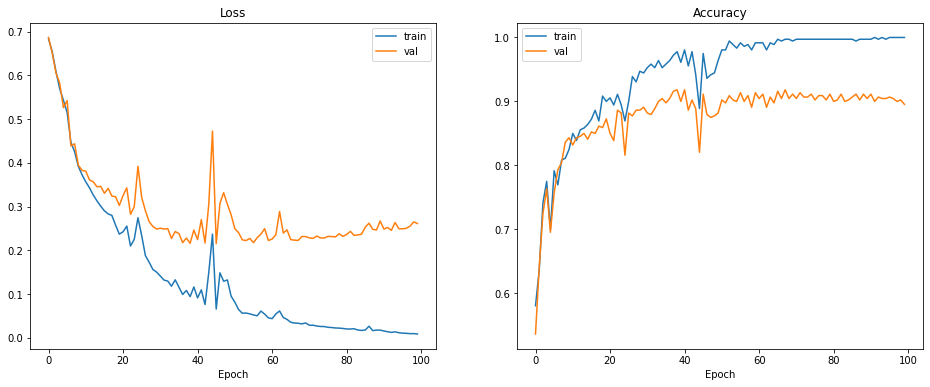

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(train_loss_epoch, label = 'train') 
axs[0].plot(val_loss_epoch, label = 'val') 
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].plot(train_acc_epoch, label = 'train') 
axs[1].plot(val_acc_epoch, label = 'val') 
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()
